# Algorithmic Trading Bot using Moving Average Crossover Strategy
This notebook outlines the creation and backtesting of a simple trading bot based on the Moving Average Crossover strategy using the `backtrader` library.


In [2]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install git+https://github.com/happydasch/btplotting

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/happydasch/btplotting to /private/var/folders/0h/s0zvhcnd6573h3xrtcsxc8140000gn/T/pip-req-build-4n5bfg_0
  Running command git clone -q https://github.com/happydasch/btplotting /private/var/folders/0h/s0zvhcnd6573h3xrtcsxc8140000gn/T/pip-req-build-4n5bfg_0
  Resolved https://github.com/happydasch/btplotting to commit 2e50b15bde3dc9081a17c2f2d85b5ee0659c9a77
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from btplotting import BacktraderPlottingLive


/Users/aryanlangeh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading BokehJS ...

Strategies

In [5]:
class MovingAverageCrossoverStrategy(bt.Strategy):
    params = (
        ("fast_ma", 50), # x days
        ("slow_ma", 200), # x days
        ("order_percentage", 0.95),
        ("ticker", "AAPL")
    )

    def __init__(self):
        self.fast_ma = bt.indicators.SMA(self.data.close, period=self.params.fast_ma)
        self.slow_ma = bt.indicators.SMA(self.data.close, period=self.params.slow_ma)
        self.crossover = bt.indicators.CrossOver(self.fast_ma, self.slow_ma)

    def next(self):
        if self.position.size == 0:
            if self.crossover > 0:
                amount_to_invest = (self.params.order_percentage * self.broker.cash)
                self.size = amount_to_invest / self.data.close

                self.buy(size=self.size)
        elif self.crossover < 0:
            self.sell(size=self.position.size)


In [6]:
class MeanReversionStrategy(bt.Strategy):
    params = (
        ('period', 20),           # Period for the moving average
        ('devfactor', 2.0),       # Bollinger band distance from the moving average
        ('order_percentage', 0.95)  # Order size as a percentage of available cash
    )

    def __init__(self):
        self.ma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.period)
        self.bollinger = bt.indicators.BollingerBands(self.data.close, period=self.params.period, devfactor=self.params.devfactor)

    def next(self):
        if self.position.size == 0:
            if self.data.close < self.bollinger.lines.bot:  # if the close price is below the bottom Bollinger band
                amount_to_invest = (self.params.order_percentage * self.broker.cash)
                self.size = amount_to_invest / self.data.close
                self.buy(size=self.size)
                
            if self.data.close > self.bollinger.lines.top:  # if the close price is above the top Bollinger band
                amount_to_invest = (self.params.order_percentage * self.broker.cash)
                self.size = amount_to_invest / self.data.close
                self.sell(size=self.size)

        elif self.position.size > 0 and self.data.close > self.ma:  # Close the long position if close price is above the moving average
            self.close()

        elif self.position.size < 0 and self.data.close < self.ma:  # Close the short position if close price is below the moving average
            self.close()


In [7]:
class PairsTradingStrategy(bt.Strategy):
    params = (
        ('window_size', 20), # data for x days
        ('zscore_threshold', 2.0), # Z-score threshold for buying/selling the spread
    )
    
    def __init__(self):
        # Retrieve the data series for the two stocks
        self.stock1 = self.datas[0]
        self.stock2 = self.datas[1]
        # Calculate the spread and mean/stddev of the spread
        self.spread = self.stock1.close - self.stock2.close
        self.zscore = (self.spread - bt.indicators.SimpleMovingAverage(self.spread, period=self.params.window_size)) / bt.indicators.StdDev(self.spread, period=self.params.window_size)

    def next(self):
        # Check conditions for going long on the spread (buy stock1, sell stock2)
        if self.zscore < -self.params.zscore_threshold:
            self.buy(data=self.stock1)
            self.sell(data=self.stock2)
        
        # Check conditions for going short on the spread (sell stock1, buy stock2)
        elif self.zscore > self.params.zscore_threshold:
            self.sell(data=self.stock1)
            self.buy(data=self.stock2)
        
        # Check conditions for closing long position on the spread
        elif self.zscore >= 0 and self.getposition(self.stock1).size > 0:
            self.close(data=self.stock1)
            self.close(data=self.stock2)

        # Check conditions for closing short position on the spread
        elif self.zscore <= 0 and self.getposition(self.stock1).size < 0:
            self.close(data=self.stock1)
            self.close(data=self.stock2)


Running Moving Average Crossover Strategy

In [9]:
cerebro = bt.Cerebro()
cerebro.addstrategy(MovingAverageCrossoverStrategy)

# Load data
data_df = yf.download("AAPL", start="2020-08-01", end="2023-08-19")

# Convert the data to backtrader format
data_bt = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data_bt)

cerebro.broker.set_cash(10000)  # Start with $100,000
cerebro.broker.setcommission(commission=0.001)  # 0.1% commission on trades

start_portfolio_value = cerebro.broker.getvalue()

cerebro.run()

end_portfolio_value = cerebro.broker.getvalue()
print(f"Starting Portfolio Value: {start_portfolio_value}")
print(f"Ending Portfolio Value: {end_portfolio_value}")


[*********************100%%**********************]  1 of 1 completed
Starting Portfolio Value: 10000
Ending Portfolio Value: 10358.596918077765


In [10]:
%matplotlib inline
cerebro.plot(iplot=False)  # Setting iplot=False ensures it uses the standard matplotlib library and not an interactive plot.


[[<Figure size 1280x960 with 5 Axes>]]

Trying mean reversion strategy

In [23]:
cerebro = bt.Cerebro()
cerebro.addstrategy(MeanReversionStrategy)
tickers = ["AAPL"]
# Load data
data_df = yf.download("RACE", start="2023-01-01", end="2023-08-19")

# Convert the data to backtrader format
data_bt = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data_bt)

cerebro.broker.set_cash(100000)  # Start with $100,000
cerebro.broker.setcommission(commission=0.001)  # 0.1% commission on trades

start_portfolio_value = cerebro.broker.getvalue()

cerebro.run()

end_portfolio_value = cerebro.broker.getvalue()
print(f"Starting Portfolio Value: {start_portfolio_value}")
print(f"Ending Portfolio Value: {end_portfolio_value}")


[*********************100%%**********************]  1 of 1 completed
Starting Portfolio Value: 100000
Ending Portfolio Value: 110194.42447902345


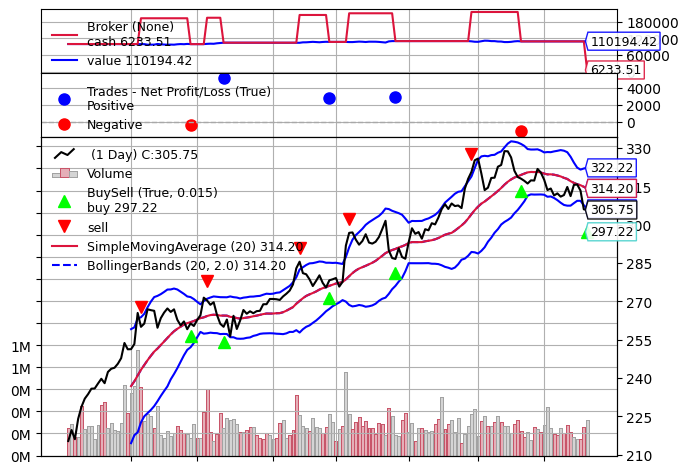

[[<Figure size 640x480 with 4 Axes>]]

In [24]:
%matplotlib inline
cerebro.plot(iplot=False)  # Setting iplot=False ensures it uses the standard matplotlib library and not an interactive plot.

Running Pairs Strategy

In [16]:
cerebro = bt.Cerebro()

cerebro.addstrategy(PairsTradingStrategy)

data_df_1 = yf.download("NDX", start="2022-01-01", end="2023-08-19")
data_df_2 = yf.download("SPY", start="2022-01-01", end="2023-08-19")

# Convert the data to backtrader format
data_bt_1 = bt.feeds.PandasData(dataname=data_df_1)
data_bt_2 = bt.feeds.PandasData(dataname=data_df_2)
cerebro.adddata(data_bt_1)
cerebro.adddata(data_bt_2)
cerebro.addanalyzer(BacktraderPlottingLive)
cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.001)
start_portfolio_value = cerebro.broker.getvalue()
cerebro.run()
end_portfolio_value = cerebro.broker.getvalue()
print(f"Starting Portfolio Value: {start_portfolio_value}")
print(f"Ending Portfolio Value: {end_portfolio_value}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Starting Portfolio Value: 100000
Ending Portfolio Value: 101872.95317401126


Open browser at http://localhost:80


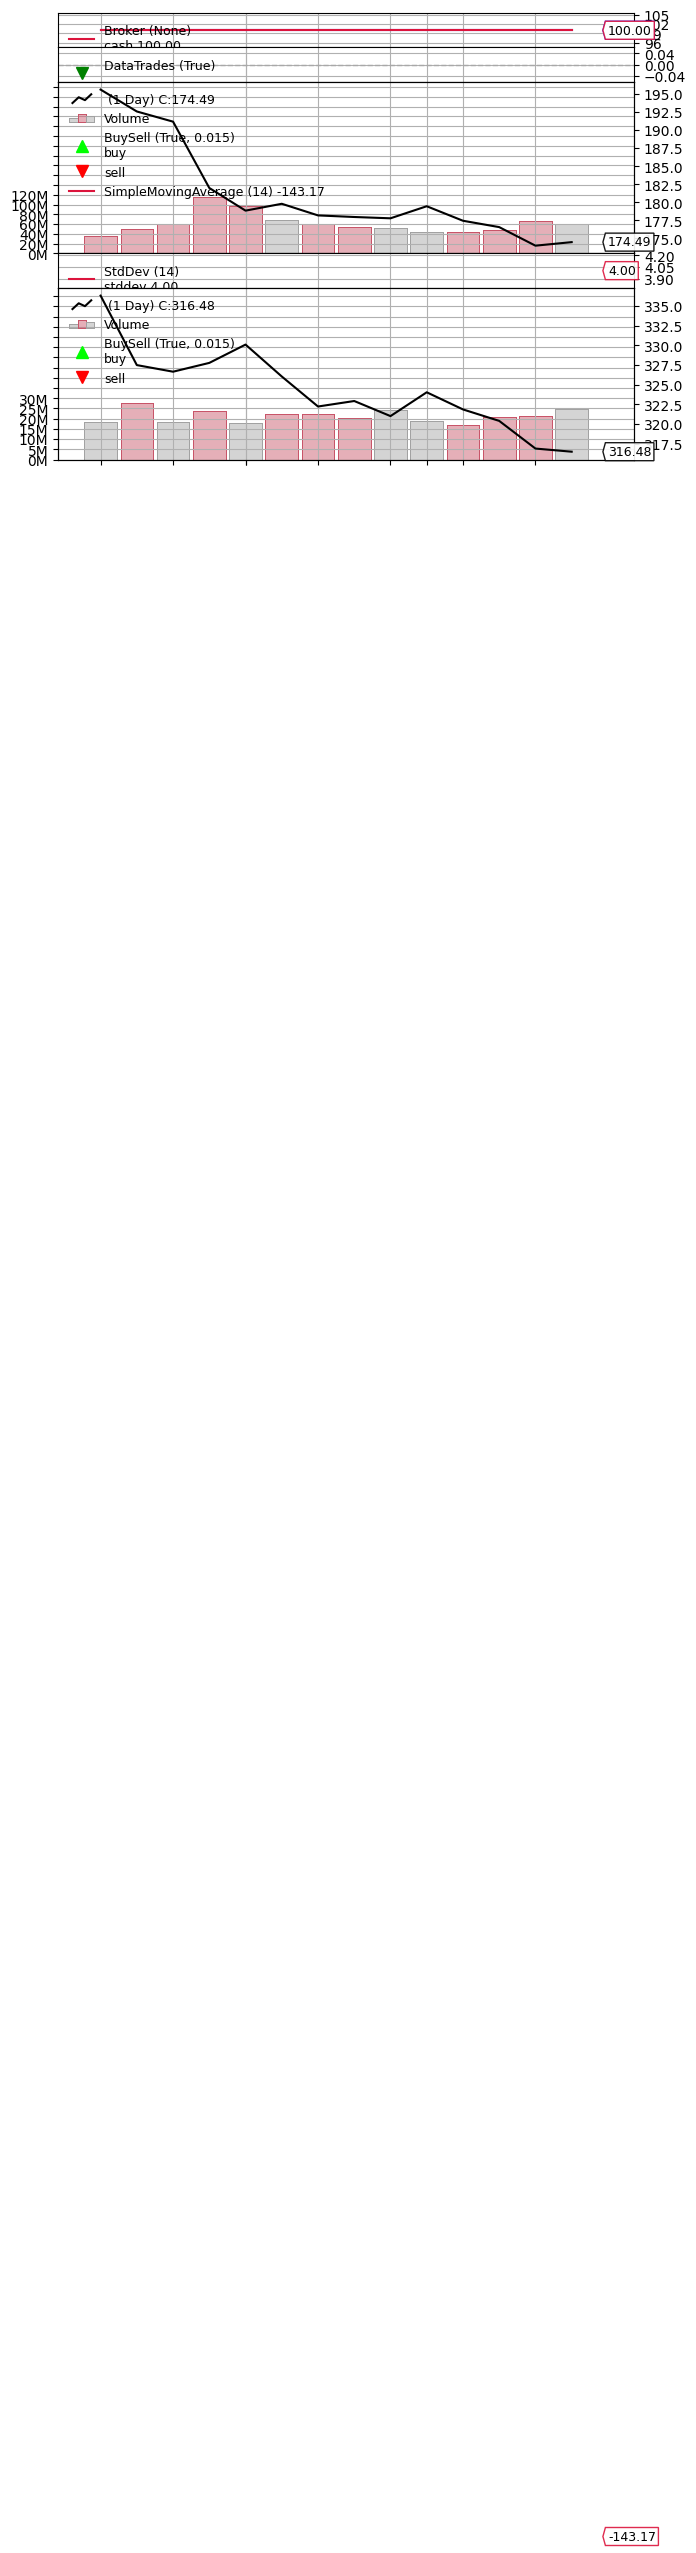

[[<Figure size 640x480 with 7 Axes>]]

In [14]:
%matplotlib inline

cerebro.plot(iplot=False)